In [1]:
from Network_PER import *
from DriveSim import *

pygame 2.1.2 (SDL 2.0.18, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
#시뮬레이션 학습 코드
EXP_COUNT = 4
n_runs = 10000
train_scores = np.zeros([EXP_COUNT,n_runs//100])
train_losses = np.zeros([EXP_COUNT,n_runs//100])

for exps in range(EXP_COUNT):
    wins = 0
    agent = Agent(lr=0.0005, gamma=0.99, n_actions=5, batch_size=64, epsilon=1.0, input_dims=[4, 6], per_on=True)
    sim = DriveSimulator()
    epsilons = []
    avg_score = 0.0
    avg_loss = 0.0
    
    for i in range(n_runs):
        over = False
        sim.reset(frame_rate=300)

        state = sim.get_sim_state()
        while not over:
            #print(agent.choose_action(state))
            action, pred = agent.choose_action(state)
            state_, stpRwd, sim_over = sim.step(action)
            over = sim_over

            agent.store_transition(state, action, stpRwd, state_, over, pred)
            state = state_

        Loss = agent.learn(exps)
        agent.epsilon = 1.0 - (float(i)/float(n_runs))
        #scores.append(sim.agtRwd)
    
        avg_score += sim.agtRwd
        avg_loss += Loss
        if sim.episode_count % 100 == 0:
            avg_score /= 100
            avg_loss /= 100
            print('Episode', sim.episode_count, ', average score(last 100 episodes):', avg_score, \
                'average loss:', avg_loss, 'wins:', sim.win_count, 'eps:', agent.epsilon)
            train_scores[exps, i//100] = avg_score
            train_losses[exps, i//100] = avg_loss
            avg_score = 0.0
            avg_loss = 0.0
            epsilons.append(agent.epsilon)

    agent.save_model('./models/q_20221118(0)' + str(exps))
np.savetxt('20221118_scores(0).csv', train_scores, delimiter=",")
np.savetxt('20221118_losses(0).csv', train_losses, delimiter=",")

Use Prioritized Sampling: True
Episode 100 , average score(last 100 episodes): -2.0 average loss: 0.9317820462584495 wins: 20 eps: 0.9901
Episode 200 , average score(last 100 episodes): -2.0 average loss: 0.45030293926596643 wins: 40 eps: 0.9801
Episode 300 , average score(last 100 episodes): -3.95 average loss: 0.23300570461899042 wins: 49 eps: 0.9701
Episode 400 , average score(last 100 episodes): -2.3 average loss: 0.17242631101515143 wins: 67 eps: 0.9601
Episode 500 , average score(last 100 episodes): -2.75 average loss: 0.15976189106702804 wins: 82 eps: 0.9501
Episode 600 , average score(last 100 episodes): -3.5 average loss: 0.15263600626029075 wins: 92 eps: 0.9401
Episode 700 , average score(last 100 episodes): -3.65 average loss: 0.16217330986633896 wins: 101 eps: 0.9301
Episode 800 , average score(last 100 episodes): -3.35 average loss: 0.1584960765670985 wins: 113 eps: 0.9201
Episode 900 , average score(last 100 episodes): -3.35 average loss: 0.1592463955935091 wins: 124 eps:

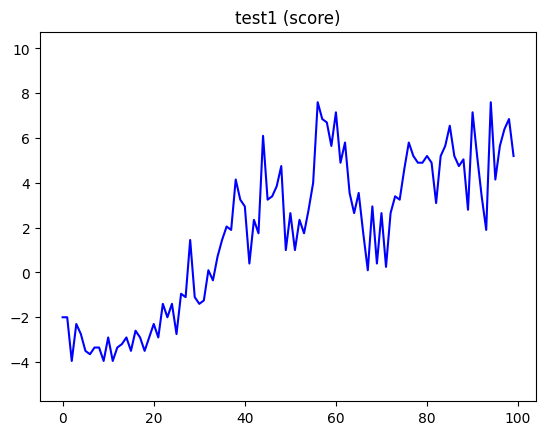

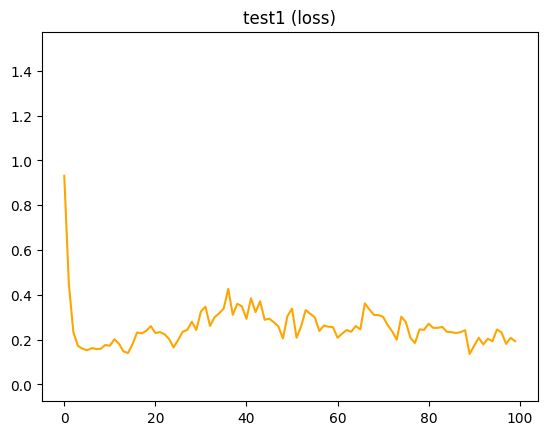

<Figure size 640x480 with 0 Axes>

In [8]:

def save_graph(date, label):
    scores = np.genfromtxt(date + '_scores(0).csv', delimiter=',')
    losses = np.genfromtxt(date + '_losses(0).csv', delimiter=',')

    # Plot Score
    plt.title(label + ' (score)')
    for i in range(EXP_COUNT):
        plt.plot(scores, 'b')
        plt.plot(10.0 * np.ones_like(scores[i]), 'gray') #Score 상한선
        plt.plot(-5.0 * np.ones_like(scores[i]), 'gray') #Score 하한선
    plt.show()
    plt.savefig(date + '_score.png')
    #plt.show()

    for i in range(EXP_COUNT):
        plt.title(label + ' (loss)')
        #Plot Loss
        plt.plot(losses, 'orange')
        plt.plot(1.5 * np.ones_like(losses[i]), 'gray') #Loss 상한선
        plt.plot(np.zeros_like(losses[i]), 'gray') #Loss 하한선
    plt.show()
    plt.savefig(date + '_loss.png')
    #plt.show()

save_graph(date = '20221118', label = 'test1')

In [ ]:
# 이 밑에는 예전에 쓰던 코드. . .

In [ ]:
#이전에 저장한 학습 데이터 불러오기
train_scores_2 = np.genfromtxt('20221014_concat_train_scores.csv', delimiter=',')

for exps in range(EXP_COUNT):
    plt.plot(train_scores_1[exps], 'b')
plt.plot(train_scores_1.mean(axis=0), 'r')
plt.show()

for exps in range(EXP_COUNT):
    print(train_scores_2[exps])
    plt.plot(train_scores_2[exps], 'b')
plt.plot(train_scores_2.mean(axis=0), 'r')
plt.show()

plt.plot(train_scores_2.mean(axis=0), 'r')
plt.plot(train_scores_1.mean(axis=0), 'b')
plt.savefig('compare_20221004_per')

In [ ]:
#학습 데이터 비교!!!!!
scores_Random = np.genfromtxt('20221017_concat_train_scores.csv', delimiter=',')
scores_Error_PER = np.genfromtxt('20221016_concat_train_scores.csv', delimiter=',')
scores_Reward_PER = np.genfromtxt('20221014_concat_train_scores.csv', delimiter=',')

plt.plot(scores_Random.mean(axis=0), 'k', label='Random')
plt.plot(scores_Error_PER.mean(axis=0), 'b', label='TD-Error based')
plt.plot(scores_Reward_PER.mean(axis=0), 'r', label='Reward based')
plt.legend()
plt.savefig("compare_sampling_methods_20221017.png")

In [ ]:
score_max = scores_Random.min(axis=0)
score_min = scores_Random.max(axis=0)
plt.fill_between(range(100), score_max, score_min, color = 'gray', alpha = 0.1)

score_max = scores_Error_PER.min(axis=0)
score_min = scores_Error_PER.max(axis=0)
plt.fill_between(range(100), score_max, score_min, color = 'b', alpha = 0.1)

score_max = scores_Reward_PER.min(axis=0)
score_min = scores_Reward_PER.max(axis=0)
plt.fill_between(range(100), score_max, score_min, color = 'r', alpha = 0.1)


plt.plot(scores_Random.mean(axis=0), 'gray', label='Random')
plt.plot(scores_Error_PER.mean(axis=0), 'b', label='TD-Error based')
plt.plot(scores_Reward_PER.mean(axis=0), 'r', label='Reward based')

plt.xlabel('Episodes/100')
plt.ylabel('Average Reward (during last 100 episodes)')
plt.legend()

plt.savefig("compare_sampling_methods_with_range_20221017.png")

In [ ]:
score_max = scores_Random.min(axis=0)
score_min = scores_Random.max(axis=0)
plt.fill_between(range(100), score_max, score_min, color = 'gray', alpha = 0.1)

score_max = scores_Reward_PER.min(axis=0)
score_min = scores_Reward_PER.max(axis=0)
plt.fill_between(range(100), score_max, score_min, color = 'orange', alpha = 0.1)


plt.plot(scores_Random.mean(axis=0), 'gray', label='Random')
plt.plot(scores_Reward_PER.mean(axis=0), 'orange', label='Reward based')

plt.xlabel('Episodes/100')
plt.ylabel('Average Reward (during last 100 episodes)')
plt.legend()

plt.savefig("compare_aw_with_range_20221017.png")

In [ ]:
np.savetxt('20221017_concat_train_scores.csv', train_scores_1, delimiter=",")